# Curso 'Modelado y aprendizaje no supervisado'

## Trabajo Práctico Final
Luego de un extenso recorrido hemos llegado al TP Final del último curso! Felicitaciones por haber llegado al último escalón de esta serie! Solo queda un paso más...

En este TP el objetivo será realizar un agrupamiento de los clientes de una empresa para entender mejor las distintas características que tienen y establecer estrategias de marketing personalizadas (Segmentación de clientes). Por lo que el objetivo principal es generar un análisis de clustering y poder realizar una descripción de las principales características que presentan los clientes que pertenecen a cada cluster.

El dataset que vamos a utilizar es marketing_campaign.csv. En el siguiente enlace pueden encontrar detallada la información de cada uno de los atributos que conforman este dataset.

El trabajo consistirá en tres secciones:

Preprocesado de los datos: verificar la calidad de los datos, seleccionar las variables de interés, estandarizar los datos.
Reducción de dimensionalidad: realizar un análisis de PCA sobre los datos, determinando el número de componentes principales óptimo según un criterio previamente establecido por el/la estudiante. Realizar un gráfico de puntos de los primeros componentes principales.
Clustering: Realizar k-means a partir del resultado del PCA (es decir, no lo hagan sobre los datos originales!) considerando el valor óptimo de k. Llevar a cabo un análisis de clustering con otro método según corresponda (ver más abajo). Realizar distintas medidas de validación interna y externa.

In [23]:
!pip install kneed


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\sebag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\sebag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [25]:
#importo librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import adjusted_rand_score
import warnings

In [26]:
#importo el dataset
df = pd.read_csv('marketing_campaign.csv',delimiter='\t')

In [27]:
df.shape


(2240, 29)

In [28]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## ZONA PREPROCESADO
Aquí tendrá que:

Exploración de los datos.
Chequear la calidad de los datos (esto incluye detectar si existen outliers y, en caso de que los hubiere, decidir qué hacer con ellos).
Seleccionar los atributos de interés: para los siguientes pasos solo nos van a interesar las variables numéricas! OJO que en el dataset existen variables que son solo dicotómicas (tomar valores 0 ó 1), esas variables no deben ser tenidas en cuenta para los siguientes pasos. Guarde las variables categóricas en una tabla separada ya que luego serán tenidas en cuenta para realizar validaciones externas.
Con la variable Year_Birth podría establecer la edad de los clientes, considerando que la edad aproximada será 2023 - Year_Birth.
Estandarizar los datos.

In [29]:
#examino la tabla para ver si hay valores nulos
df.isnull().sum()




ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [30]:
#relleno los valores nulos con la media
df['Income'].fillna(df['Income'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [31]:
#agregamos una columna con la edad de los clientes (Los datos fueron tomados en 2021,
#pero la practica pide que se agregue una columna con la edad de los clientes en 2023)
df['Age'] = 2023 - df['Year_Birth']


In [32]:
#agrego una columna que indique el numero de meses que el cliente lleva en la empresa usando la fecha de ingreso (Dt_Customer)
#tener en cuenta el formato de la fecha
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Months_In_Company'] = (pd.to_datetime('2023-10-01') - df['Dt_Customer']).dt.days / 30
df['Months_In_Company'] = df['Months_In_Company'].astype(int)
df.head()




,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,3,11,1,66,134
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,3,11,0,69,116
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,3,11,0,58,123
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,3,11,0,39,117
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,3,11,0,42,118


In [33]:
#creo una nueva columna que indique el dinero gastado por el cliente en la empresa
#los datos suministrados son en dos años (hasta 2021), pero vamosa suponer que
#fueron hasta 2023 (año actual)
df['Dinero_gastado'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company,Dinero_gastado
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,3,11,1,66,134,1617
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,3,11,0,69,116,27
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,3,11,0,58,123,776
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,3,11,0,39,117,53
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,3,11,0,42,118,422


In [34]:
#Creo otra columna denominada hijos, que indique el total de hijos que tiene el cliente
df['Hijos'] = df['Kidhome'] + df['Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company,Dinero_gastado,Hijos
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,3,11,1,66,134,1617,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,3,11,0,69,116,27,2
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,3,11,0,58,123,776,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,3,11,0,39,117,53,1
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,3,11,0,42,118,422,1


In [35]:
#Elimino las columnas que no voy a usar
df = df.drop(['Year_Birth','Dt_Customer','Kidhome','Teenhome','Complain','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Z_CostContact','Z_Revenue'], axis=1)
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2240 non-null   float64
 4   Recency              2240 non-null   int64  
 5   MntWines             2240 non-null   int64  
 6   MntFruits            2240 non-null   int64  
 7   MntMeatProducts      2240 non-null   int64  
 8   MntFishProducts      2240 non-null   int64  
 9   MntSweetProducts     2240 non-null   int64  
 10  MntGoldProds         2240 non-null   int64  
 11  NumDealsPurchases    2240 non-null   int64  
 12  NumWebPurchases      2240 non-null   int64  
 13  NumCatalogPurchases  2240 non-null   int64  
 14  NumStorePurchases    2240 non-null   int64  
 15  NumWebVisitsMonth    2240 non-null   i

In [36]:
#Examino el dataframe con mas detalle
df.describe()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,52247.251354,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,54.194196,123.985268,605.798214,0.950446
std,3246.662198,25037.797168,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,11.984069,6.747289,602.249288,0.751803
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,112.000000,5.000000,0.000000
25%,2828.250000,35538.750000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,46.000000,118.000000,68.750000,0.000000
50%,5458.500000,51741.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,53.000000,124.000000,396.000000,1.000000
75%,8427.750000,68289.750000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,64.000000,130.000000,1045.500000,1.000000
max,11191.000000,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,130.000000,136.000000,2525.000000,3.000000


Examinando las filas de valores maximos y minimos, se observa a simple vista que hay valores extraños en las columnas Income y edad. Voy a graficarlos para verlos mejor.

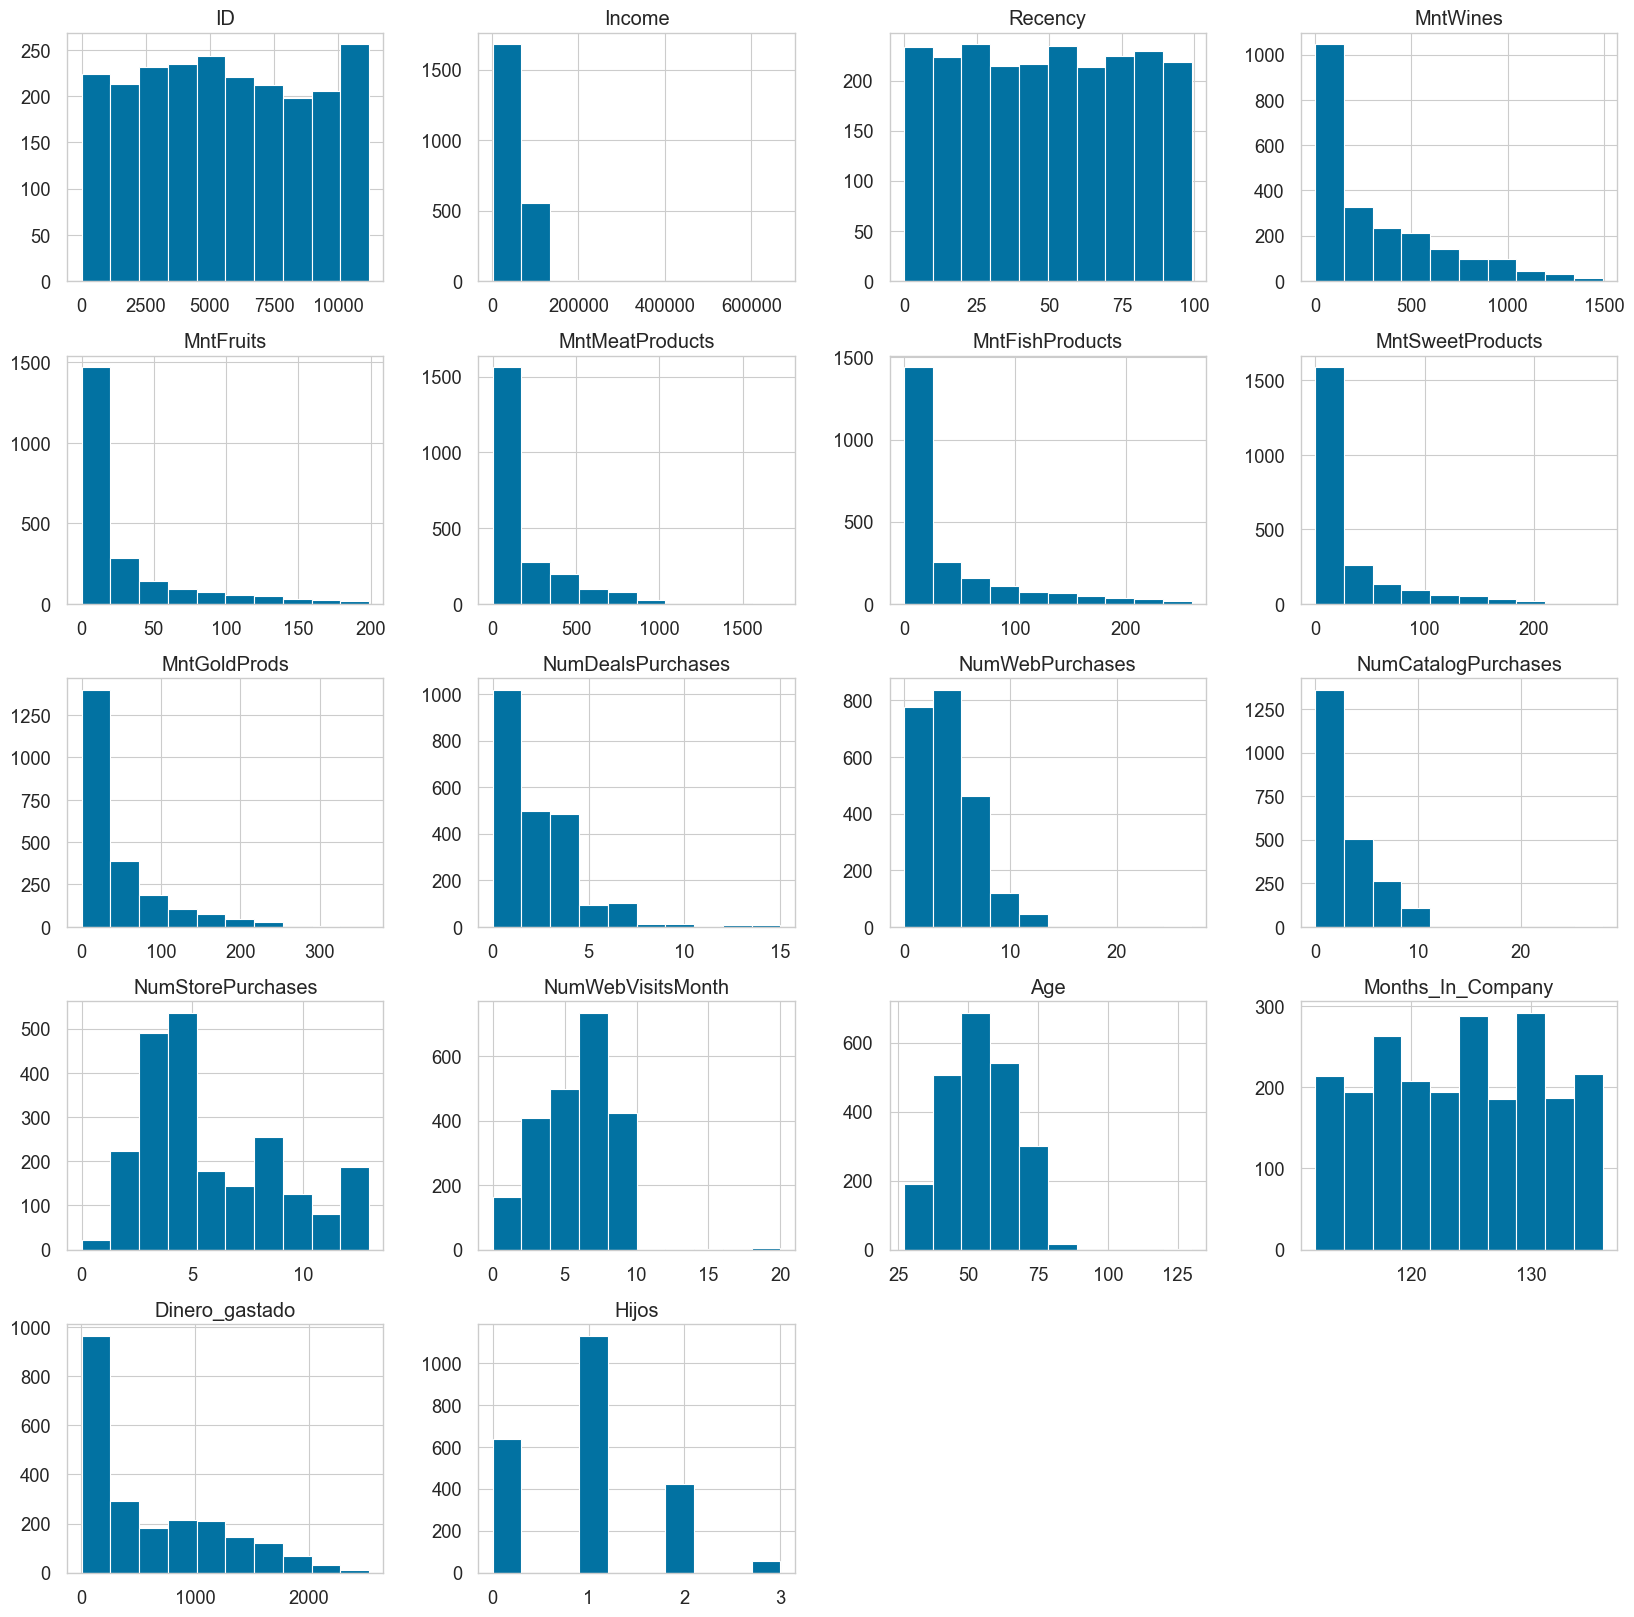

In [37]:
#grafico las variables numericas
df.hist(figsize=(20,20))
plt.show()

En estas graficas podemos ver como hay valores maximos en Income y edad, que son muy superiores a los valores medios. 

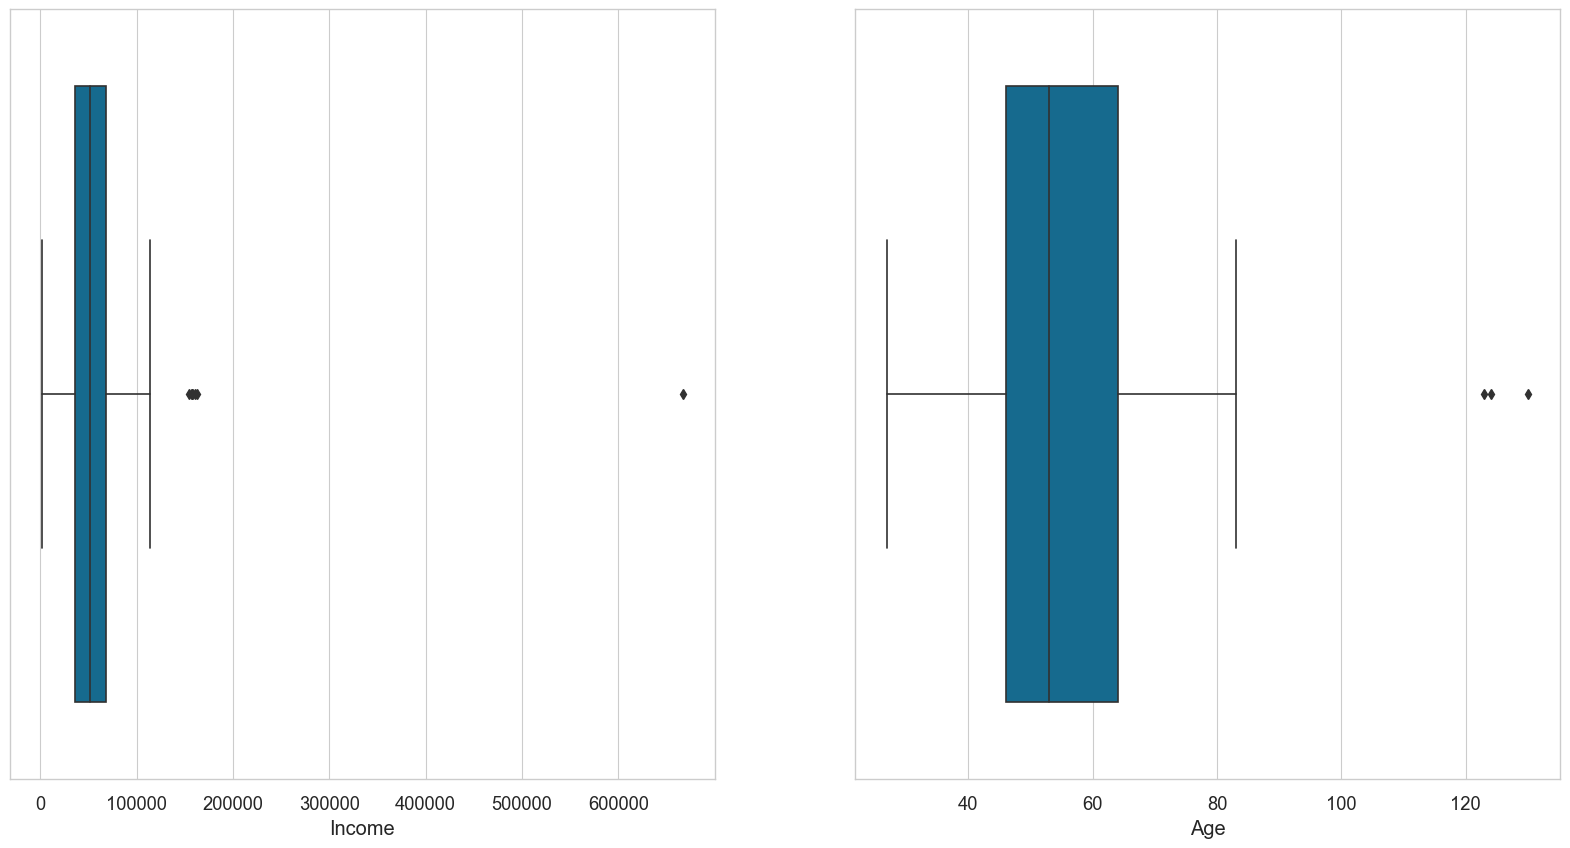

In [38]:
#Examino con mas detalle las variables con valores anormales
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x=df['Income'], ax=ax[0])
sns.boxplot(x=df['Age'], ax=ax[1])
plt.show()


En la grafica anterior podemos observar con mayor detalle los valores atipicos de la columna Income y edad. Los eliminamos.

In [39]:
#Eliminamos los outliers en Age e Income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
df.shape

(2236, 20)

creare dos nuevos dataframes, uno con las variables numericas y otro con las categoricas.

In [40]:
# dataframe con las variables categoricas
df_cat = df.select_dtypes(include=['object'])
df_cat.head()


,Education,Marital_Status
0,Graduation,Single
1,Graduation,Single
2,Graduation,Together
3,Graduation,Together
4,PhD,Married


In [41]:
#dataframe con las variables numericas
df_num = df.select_dtypes(include=['float64','int32','int64'])
df_num.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
0,5524,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,66,134,1617,0
1,2174,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,69,116,27,2
2,4141,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,58,123,776,0
3,6182,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,39,117,53,1
4,5324,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,42,118,422,1


<Axes: >

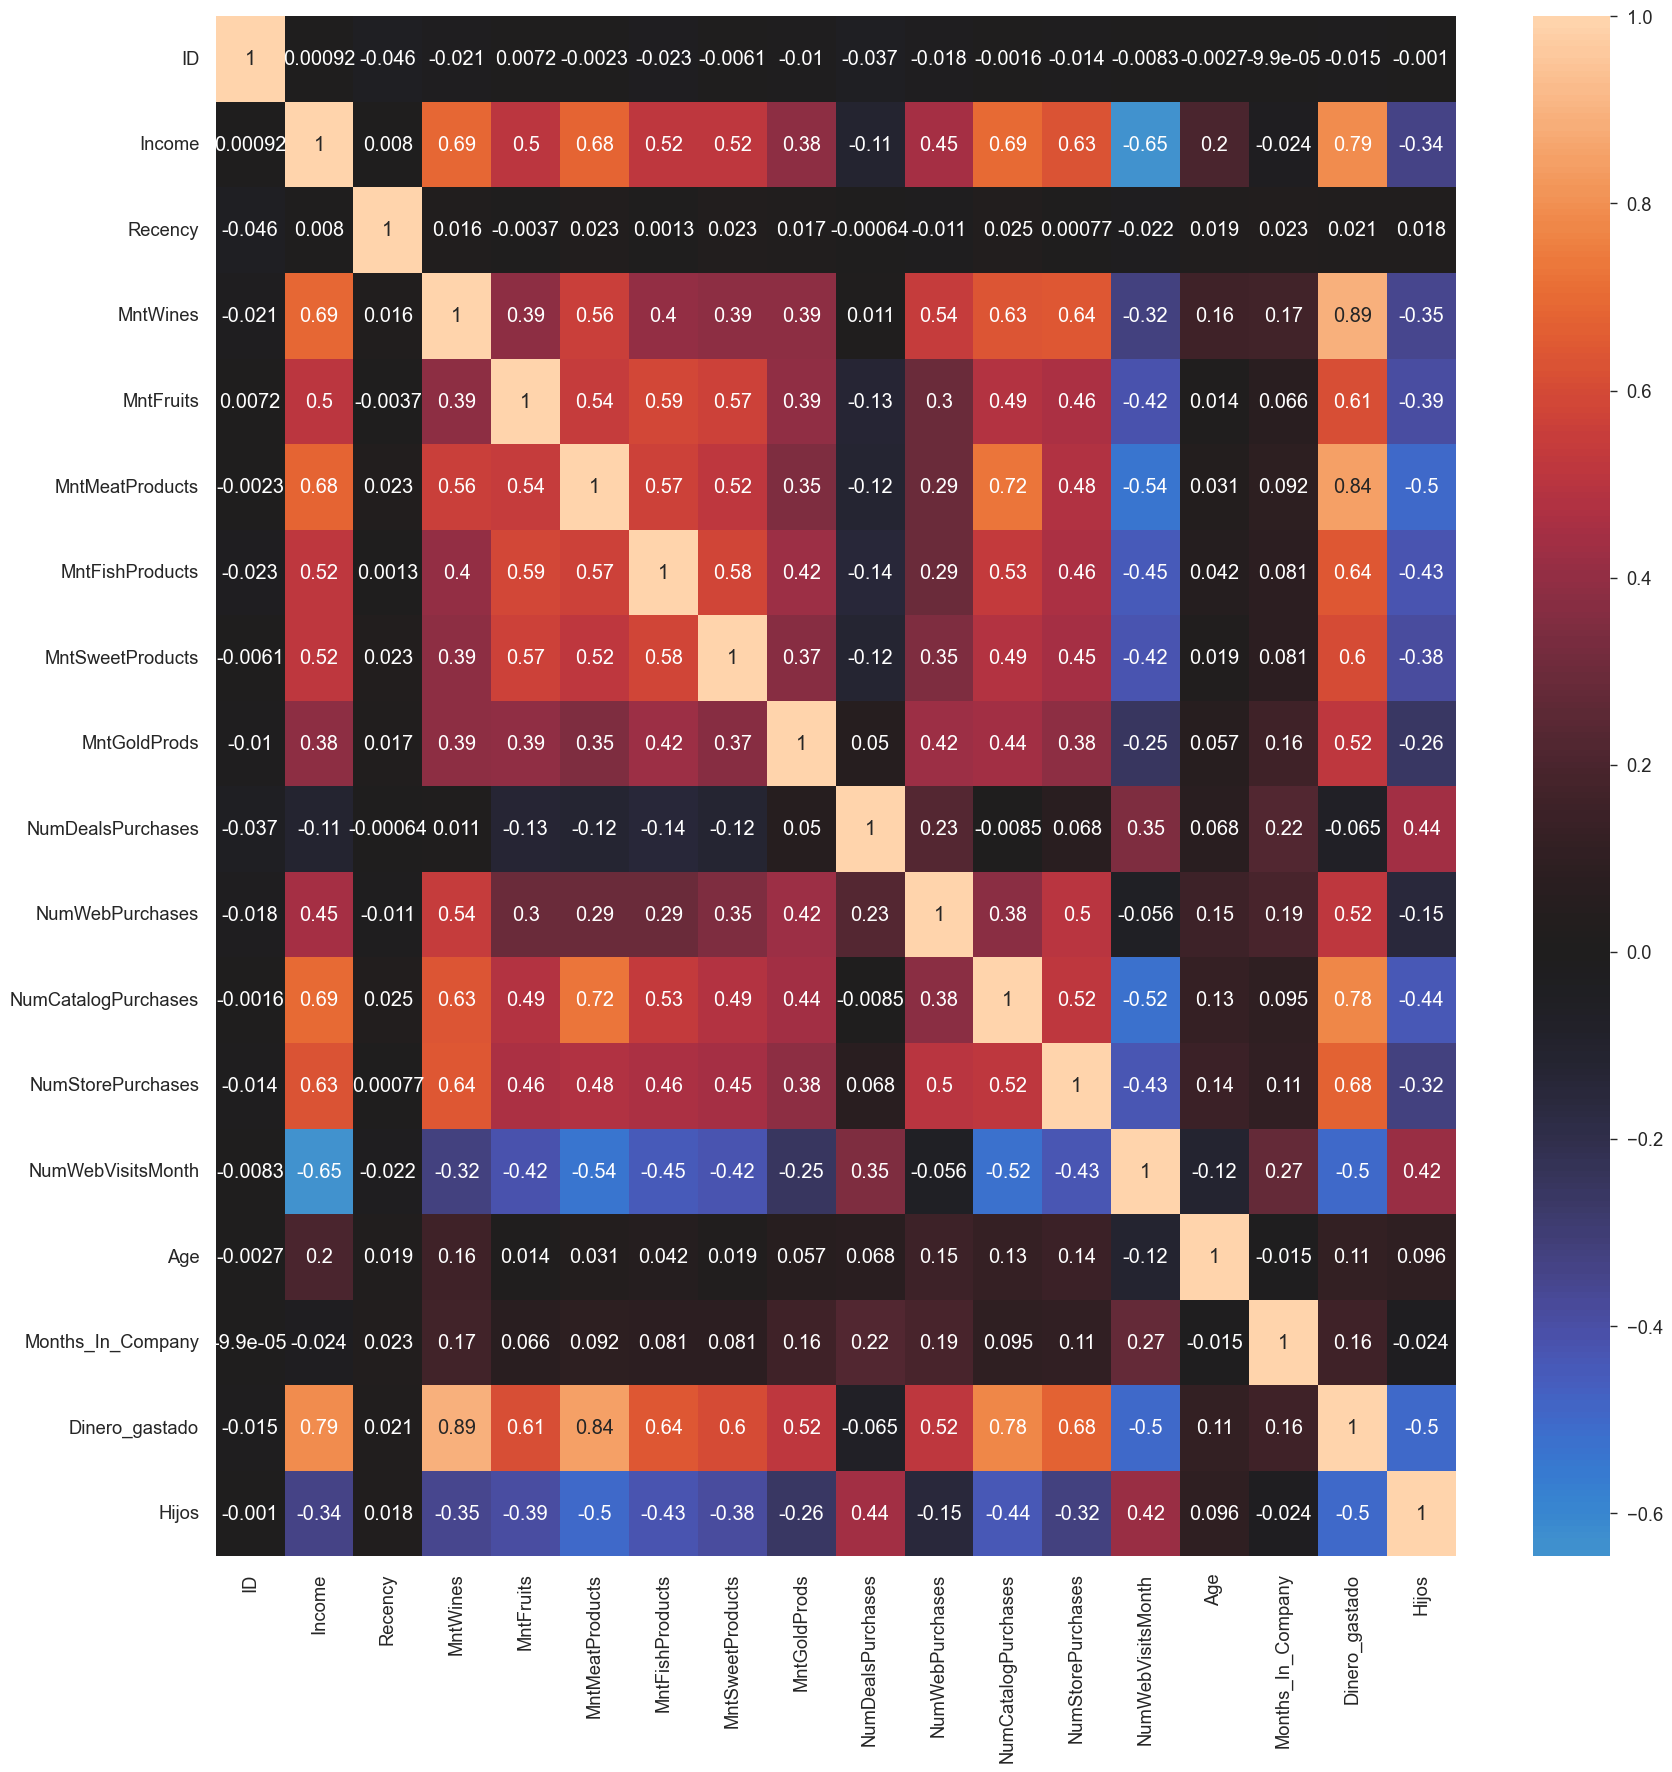

In [42]:
#ploteo la matriz de correlacion
corrmat= df_num.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)


Voy a estandarizar los datos numericos para poder trabajar con ellos.

In [43]:
#Estandarizo las variables numericas
df_num = (df_num - df_num.mean()) / df_num.std()
df_num.head()



,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
0,-0.020035,0.288449,0.306787,0.983008,1.553823,1.679371,2.460518,1.475066,0.845480,0.348660,1.407324,2.509240,-0.552306,0.692710,1.016641,1.482808,1.679801,-1.264025
1,-1.052447,-0.262379,-0.383885,-0.870869,-0.636289,-0.713296,-0.650268,-0.631497,-0.729579,-0.168662,-1.110673,-0.568843,-1.167477,-0.131392,1.272979,-1.184099,-0.961987,1.394827
2,-0.446251,0.917786,-0.798289,0.362078,0.572049,-0.177161,1.344295,-0.147229,-0.038090,-0.685984,1.407324,-0.226833,1.293207,-0.543443,0.333072,-0.146969,0.282478,-1.264025
3,0.182750,-1.182356,-0.798289,-0.870869,-0.560768,-0.651264,-0.503878,-0.583070,-0.748787,-0.168662,-0.750959,-0.910852,-0.552306,0.280659,-1.290405,-1.035938,-0.918788,0.065401
4,-0.081671,0.295688,1.549998,-0.389574,0.421006,-0.217039,0.154876,-0.001949,-0.556706,1.383305,0.328183,0.115176,0.062865,-0.131392,-1.034066,-0.887776,-0.305694,0.065401


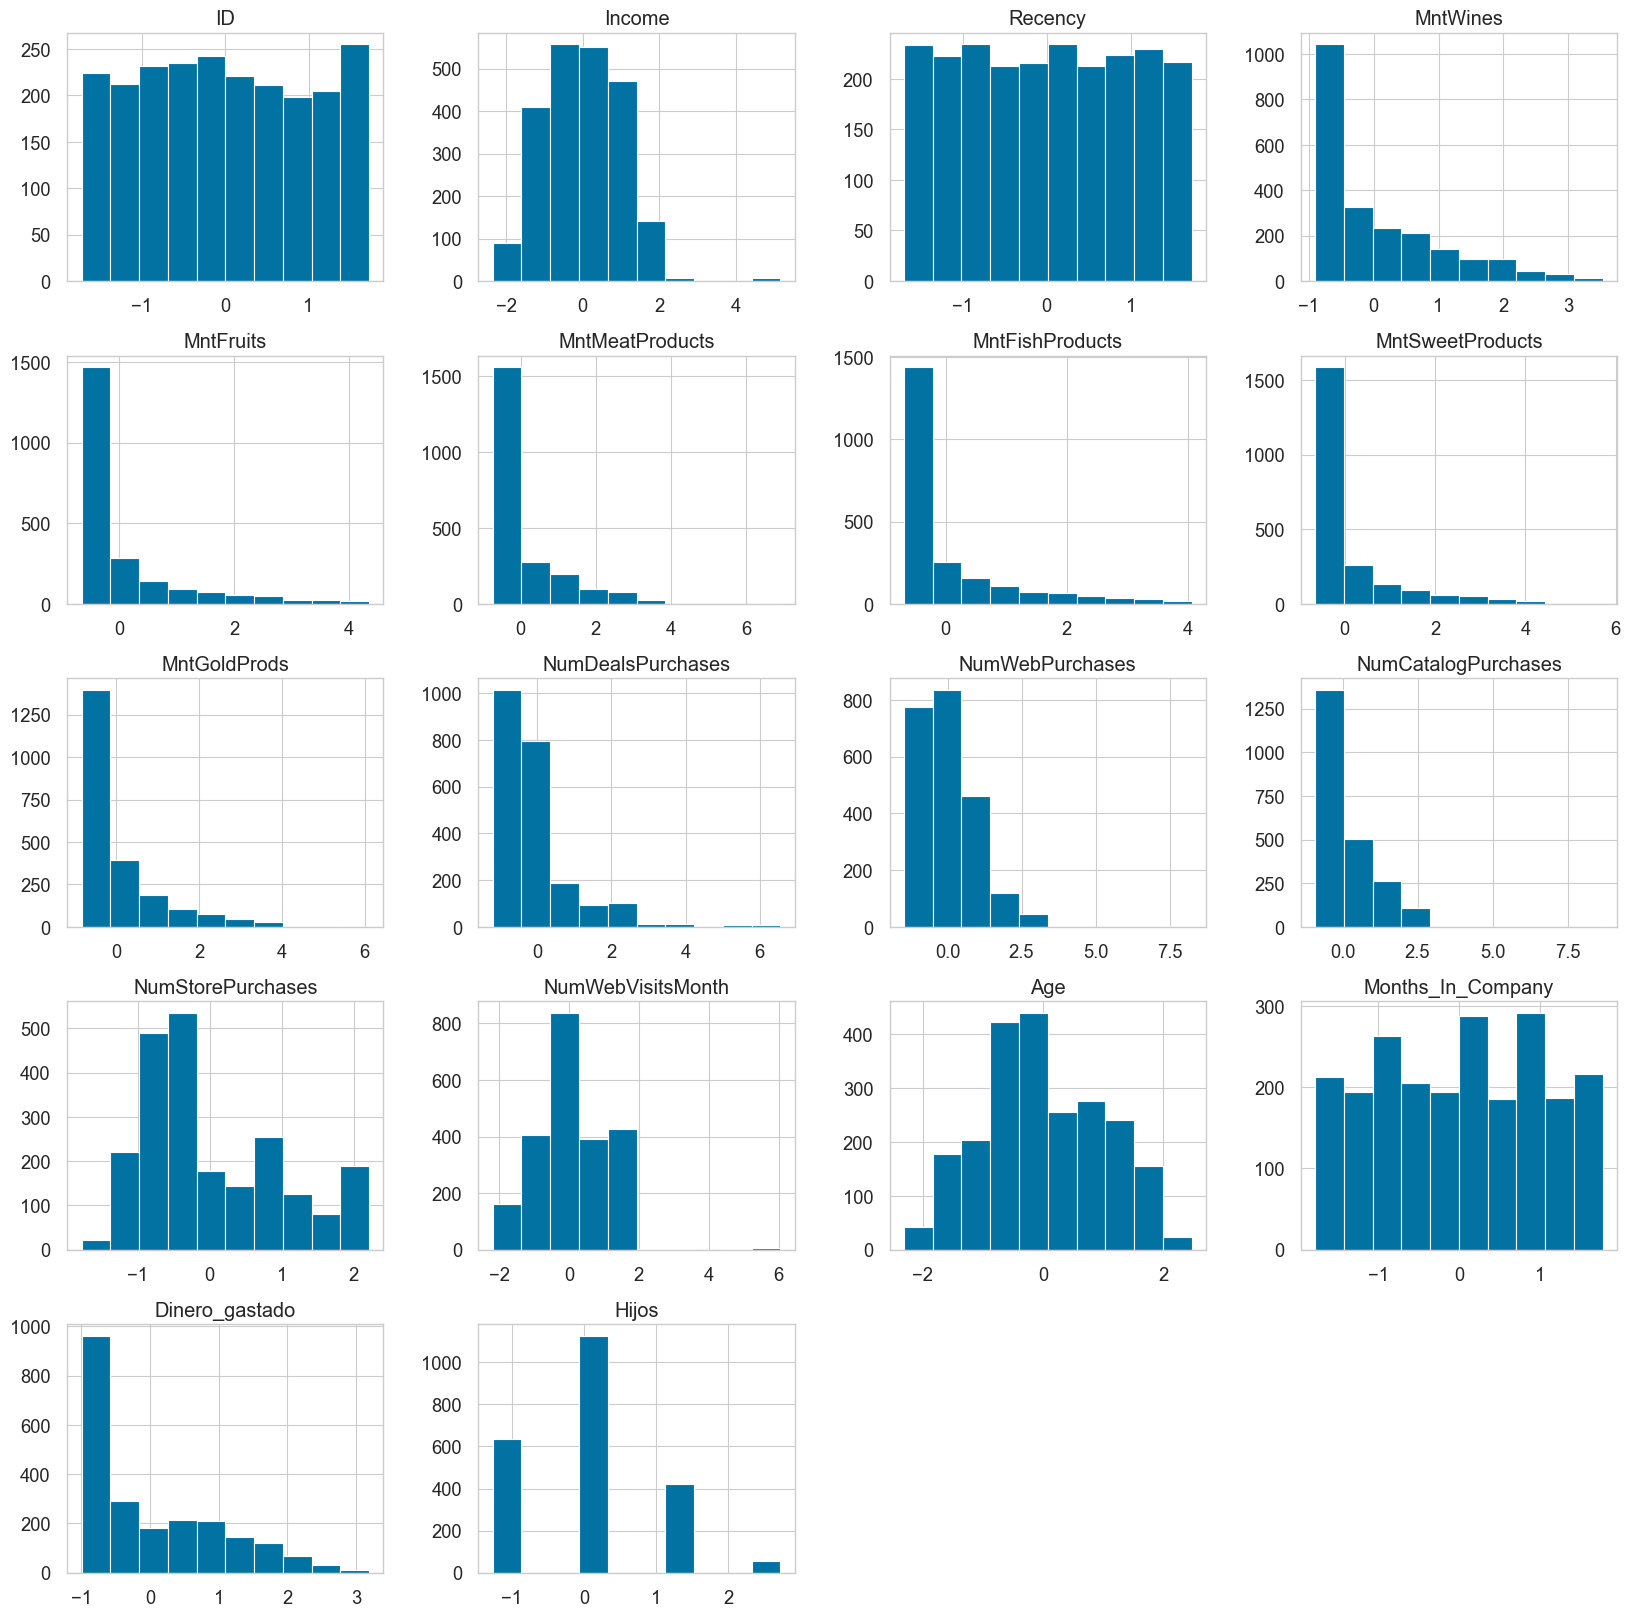

In [44]:
df_num.hist(figsize=(20,20))
plt.show()


# ZONA REDUCCIÓN DE LA DIMENSIONALIDAD
## Aquí tendrá que:

Llevar a cabo un PCA con las variables númericas ya estandarizadas del dataset
Determinar el número de componentes principales que serán tenidos en cuenta para los siguientes análisis de este Trabajo Práctico.
Graficar la distribución de los clientes (observaciones) en los dos primeros componentes principales.
¿Cuáles son las variables originales más importantes en estos primeros componentes principales?

In [45]:
df_num.describe()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
count,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03
mean,3.495514e-17,2.287973e-16,-6.673255e-17,-6.355481e-18,-2.621636e-17,-3.495514e-17,1.986088e-17,2.224418e-17,4.766610e-18,1.906644e-17,-2.224418e-17,-7.944351e-17,-1.163847e-16,-1.715980e-16,5.243272e-17,-7.563022e-16,6.355481e-18,8.897673e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.722437e+00,-2.346035e+00,-1.696163e+00,-9.035498e-01,-6.614624e-01,-7.398809e-01,-6.868657e-01,-6.557101e-01,-8.448268e-01,-1.203306e+00,-1.470387e+00,-9.108518e-01,-1.782647e+00,-2.191646e+00,-2.315758e+00,-1.776745e+00,-9.985402e-01,-1.264025e+00
25%,-8.508184e-01,-7.687215e-01,-8.673562e-01,-8.322468e-01,-6.362888e-01,-6.689871e-01,-6.319695e-01,-6.314967e-01,-6.719545e-01,-6.859840e-01,-7.509589e-01,-9.108518e-01,-8.598911e-01,-9.554933e-01,-6.922818e-01,-8.877762e-01,-8.922041e-01,-1.264025e+00
50%,-4.145321e-02,-1.297937e-02,-4.015538e-03,-3.866032e-01,-4.600729e-01,-4.430130e-01,-4.672808e-01,-4.620032e-01,-3.838341e-01,-1.686618e-01,-3.153127e-02,-2.268335e-01,-2.447202e-01,2.806589e-01,-9.415888e-02,1.192713e-03,-3.480623e-01,6.540110e-02
75%,8.730024e-01,7.619231e-01,8.593251e-01,5.945556e-01,1.692694e-01,2.880794e-01,2.280714e-01,1.433310e-01,2.308228e-01,3.486603e-01,6.878964e-01,4.571849e-01,6.780360e-01,6.927096e-01,8.457485e-01,8.901616e-01,7.302523e-01,6.540110e-02
max,1.726438e+00,5.157770e+00,1.722666e+00,3.532090e+00,4.348103e+00,6.903359e+00,4.052509e+00,5.712405e+00,6.108479e+00,6.556526e+00,8.241887e+00,8.665405e+00,2.215963e+00,6.049369e+00,2.469225e+00,1.779131e+00,3.188444e+00,2.724253e+00


Calculamos la matriz de covarianza entre las variables

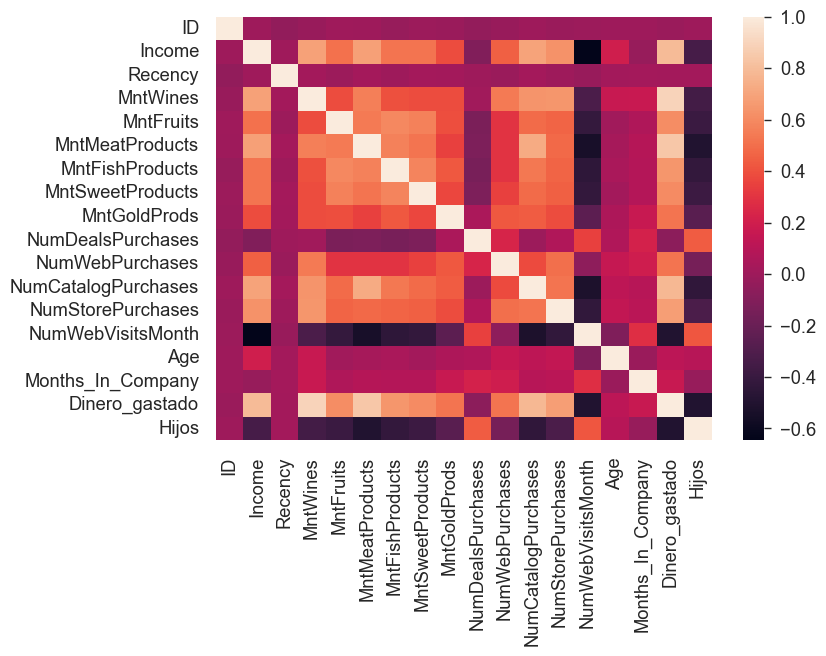

In [46]:
#Covaianza
covMatrix = df_num.cov()
#Heatmap
sns.set_style("whitegrid")
sns.heatmap(covMatrix)
plt.show()


Realizo el PCA

In [47]:
#PCA
pca = PCA()
X_pca = pca.fit_transform(df_num)

#convertimos los datos a un dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca,columns=component_names)
X_pca.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,4.280897,1.186103,1.445661,-0.311535,-0.460245,-0.228488,-1.627037,0.953580,0.409093,2.265400,-0.408723,-0.002258,0.469446,0.316410,-0.738093,0.234804,0.176570,-8.662941e-17
1,-2.549095,-0.706024,-1.885973,-0.478977,0.985721,-0.507923,-0.550716,0.597650,0.362221,0.210223,0.361206,-0.463603,0.000641,-0.095950,-0.074495,0.007492,-0.029607,1.675445e-14
2,1.938859,-0.285752,-0.179393,0.425684,1.035372,0.118337,-0.553237,-1.089211,-1.068979,-0.440290,-0.764885,0.279014,0.690538,0.990852,0.016221,-0.249966,-0.354391,1.763265e-16
3,-2.543827,-1.161264,0.525144,0.650233,0.616803,-0.124433,0.934753,-0.232636,-0.132991,0.047131,-0.298435,0.176071,0.137624,-0.161298,0.081704,0.057436,0.275530,5.788350e-15
4,-0.171148,0.184107,-0.041137,-1.145452,-0.654204,-0.915293,1.745677,0.185247,-0.420131,0.298656,-0.654548,0.456303,-0.157546,0.464814,-0.271636,-0.405111,-0.334660,-3.677761e-15


In [48]:
pca.explained_variance_ratio_

array([3.89864639e-01, 1.06069274e-01, 6.84598656e-02, 5.81854800e-02,
       5.34265164e-02, 4.78797614e-02, 4.49701164e-02, 4.05426053e-02,
       3.48788282e-02, 2.75121244e-02, 2.51536403e-02, 2.44194029e-02,
       2.18086865e-02, 1.95725619e-02, 1.46378453e-02, 1.27820663e-02,
       9.83658554e-03, 8.96368479e-33])

array([<Axes: title={'center': '% Varianza Explicada'}, xlabel='Componente'>,
       <Axes: title={'center': '% Varianza Acumulada'}, xlabel='Componente'>],
      dtype=object)

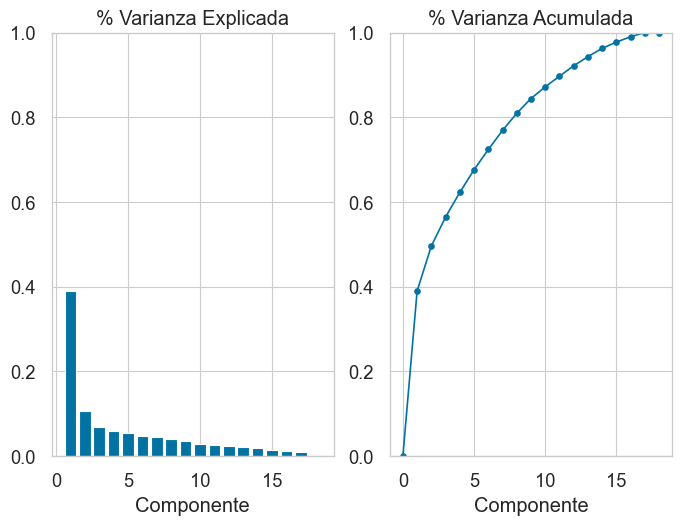

In [49]:
def plot_variance(pca, width=8, dpi=100):
    # Creo la grafica
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", title="% Varianza Explicada", ylim=(0.0, 1.0)
    )
    
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", title="% Varianza Acumulada", ylim=(0.0, 1.0)
    )
    
    fig.set(figwidth=8, dpi=100)
    return axs


plot_variance(pca)

De la grafica de varianza acumulada podemos ver que con 5 componentes principales se explica el 80% de la varianza de los datos. Este sera el numero de componentes que utilizare para el analisis de clustering.

Vamos a crear un nuevo dataframe con los 5 componentes principales.

In [50]:
#Nuevo dataframe con las 5 componentes principales
df_pca = X_pca[['PC1','PC2','PC3','PC4','PC5']]
df_pca.head()


,PC1,PC2,PC3,PC4,PC5
0,4.280897,1.186103,1.445661,-0.311535,-0.460245
1,-2.549095,-0.706024,-1.885973,-0.478977,0.985721
2,1.938859,-0.285752,-0.179393,0.425684,1.035372
3,-2.543827,-1.161264,0.525144,0.650233,0.616803
4,-0.171148,0.184107,-0.041137,-1.145452,-0.654204


Vamos a graficar la distribucion de los clientes en los dos primeros componentes principales.

C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\3675350744.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca['PC1'], X_pca['PC2'], cmap='plasma')


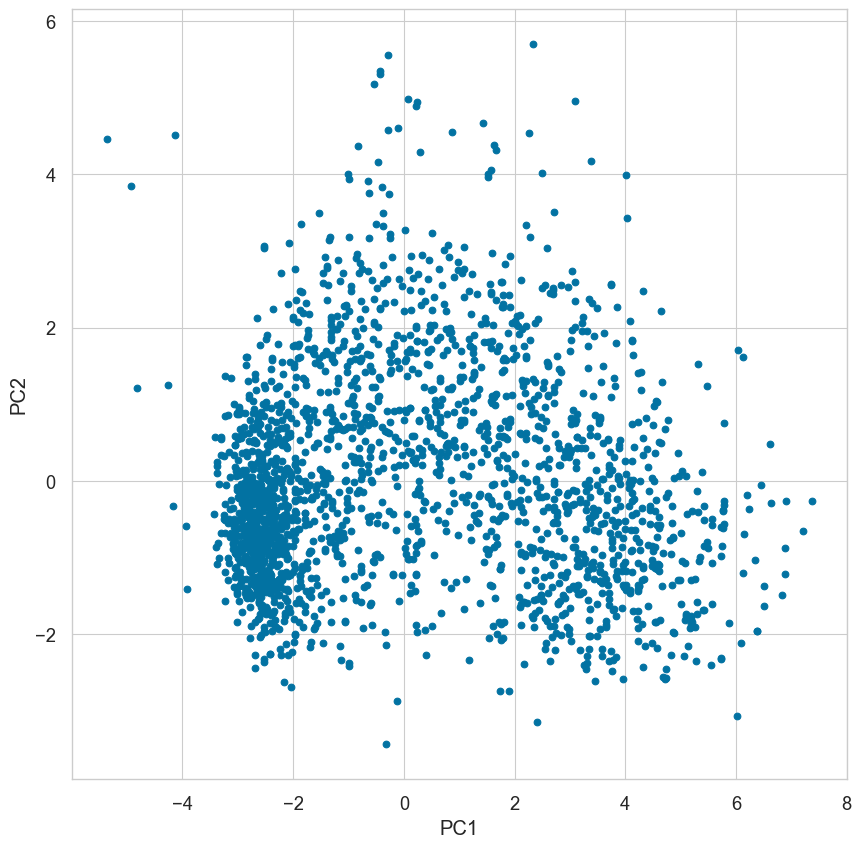

In [51]:
#Distribucion de los clientes en los dos primeros componentes
plt.figure(figsize=(10,10))
plt.scatter(X_pca['PC1'], X_pca['PC2'], cmap='plasma')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Vamos a realizar un Biplot para ver cuales son las variables mas importantes en los dos primeros componentes principales.

Text(0.5, 1.0, 'Biplotg')

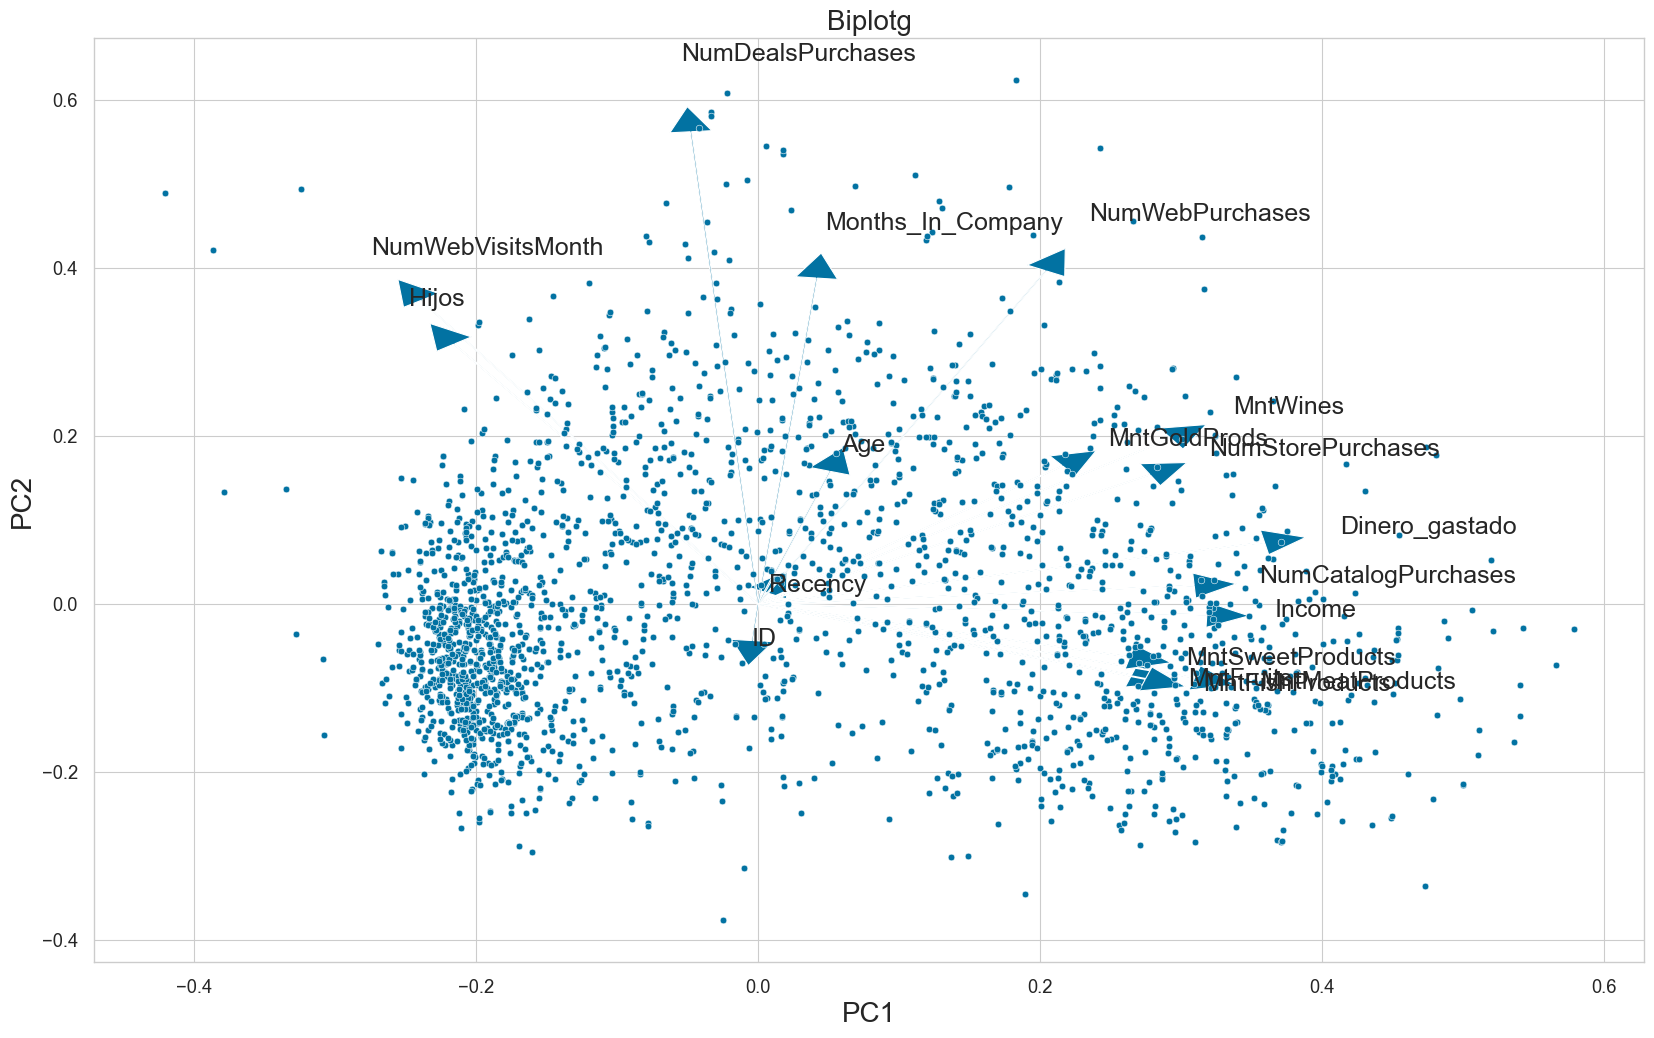

In [52]:
scalePC1 = 1.0/(X_pca['PC1'].max() - X_pca['PC1'].min())
scalePC2 = 1.0/(X_pca['PC2'].max() - X_pca['PC2'].min())
ldngs = pca.components_
features = df_num.columns

plt.figure(figsize=(20,12))

for i, features in enumerate(features):
    plt.arrow(0, 0, ldngs[0, i],
             ldngs[1, i],
              head_width=0.03,
             head_length=0.03)
    plt.text(ldngs[0, i] * 1.15,
            ldngs[1, i] * 1.15,
            features, fontsize=18)

sns.scatterplot(x=X_pca['PC1'] * scalePC1,
                y=X_pca['PC2'] * scalePC2,
                )

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title('Biplotg', fontsize=20)

De este grafico podemos ver que las variables mas importantes en los dos primeros componentes principales son:
    
    * Dinero_gastado, Income y MntMeatProducts (Para PC1)
    * NumDealsPurchases, NumWebPurchases y Months_In_Company (Para PC2)

Realizamos una tabla de Loading para confirmar que las variables mas importantes en los dos primeros componentes principales son las mencionadas anteriormente.

In [53]:
#Realizamos una tabla de Loadings
loadings = pd.DataFrame(pca.components_.T,columns=component_names,index=df_num.columns,)
loadings.iloc[:, :2]


,PC1,PC2
ID,-0.004088,-0.043398
Income,0.318475,-0.012815
Recency,0.006739,0.013088
MntWines,0.293162,0.196998
MntFruits,0.265073,-0.084520
MntMeatProducts,0.309867,-0.087864
MntFishProducts,0.274903,-0.089123
MntSweetProducts,0.263896,-0.062891
MntGoldProds,0.216083,0.164475
NumDealsPurchases,-0.047694,0.562288


## ZONA CLUSTERING
# Aquí tendrá que:

Realizar un análisis de k-means a partir de la reducción de dimensionalidad realizada en el punto anterior. Para ésto tendrá que determinar el k-óptimo.

Implementar un segúndo método de clustering sobre los datos. El método dependerá del número de documento del/de la estudiante:

** DNI par (0, 2, ..., 8): realizar un clustering jerárquico.

** DNI impar (1, 3, ..., 9): realizar DBScan.

En cualquiera de los dos casos, deberá establecer los parámetros óptimos para realizar el clustering.

Realizar una validación interna del clustering k-means con el k-seleccionado. Comparar el resultado con otro clustering con un k distinto.

Realizar una validación externa tomando como "información externa" alguna de las variables categóricas del dataset: Education o Marital_Status. ¿Están relacionadas con los grupos que se establecen?

En primer lugar vamos a realizar el analisis de k-means con el numero de clusters optimo que obtuvimos en el punto anterior (5) y lo compararemos con el que nos de el "metodo del codo".

In [54]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}


sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

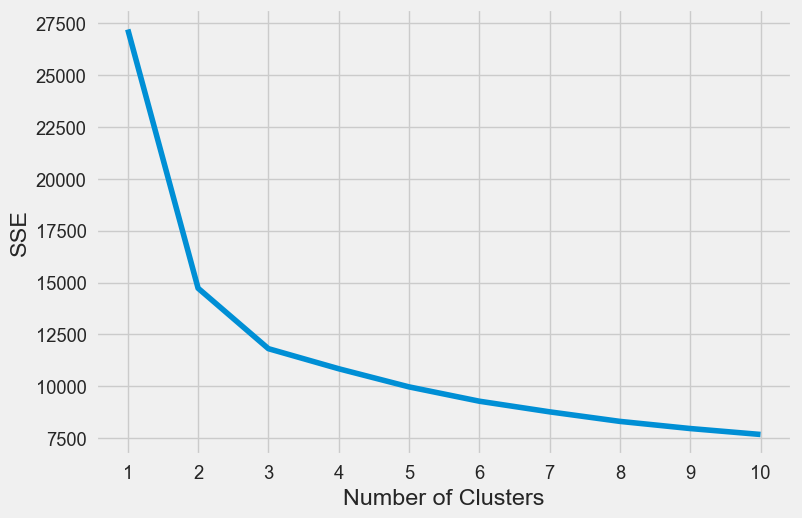

In [55]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Aplicamos el metodo del codo para ver cual es el numero de clusters optimo.

In [56]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

Tanto el metodo como la grafica nos indican que el numero de clusters optimo es 3.

In [57]:
#Kmeans
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(df_pca)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [58]:
#Centroides de los clusters generado
kmeans.cluster_centers_

array([[-2.31062588, -0.48513073,  0.11879098, -0.05293106, -0.02095442],
       [ 3.58854929, -0.59792543,  0.1442066 , -0.00423906, -0.0438917 ],
       [ 0.36431152,  1.49033138, -0.36262267,  0.09878647,  0.0832729 ]])

In [59]:
#Asignación de las observaciones a cada cluster
kmeans.labels_

array([1, 0, 1, ..., 1, 2, 0])

In [60]:
df_pca['kmeans'] = kmeans.labels_

C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\677271853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca['kmeans'] = kmeans.labels_


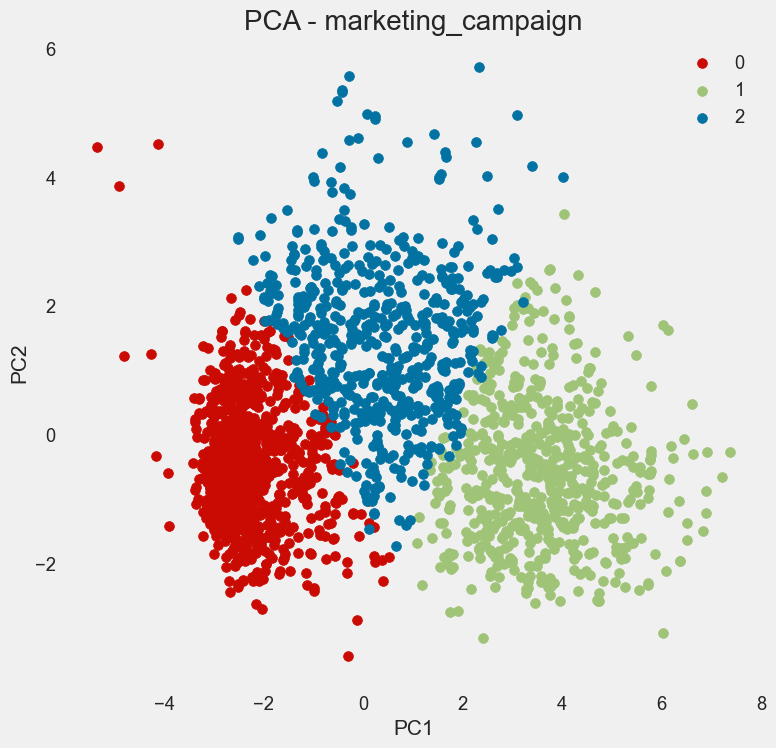

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA - marketing_campaign', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['kmeans'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1']
               , df_pca.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Realizar una validación interna del clustering k-means con el k-seleccionado. Comparar el resultado con otro clustering con un k distinto.

In [62]:
#Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_score(df_pca, kmeans.labels_)

0.35469011841538006

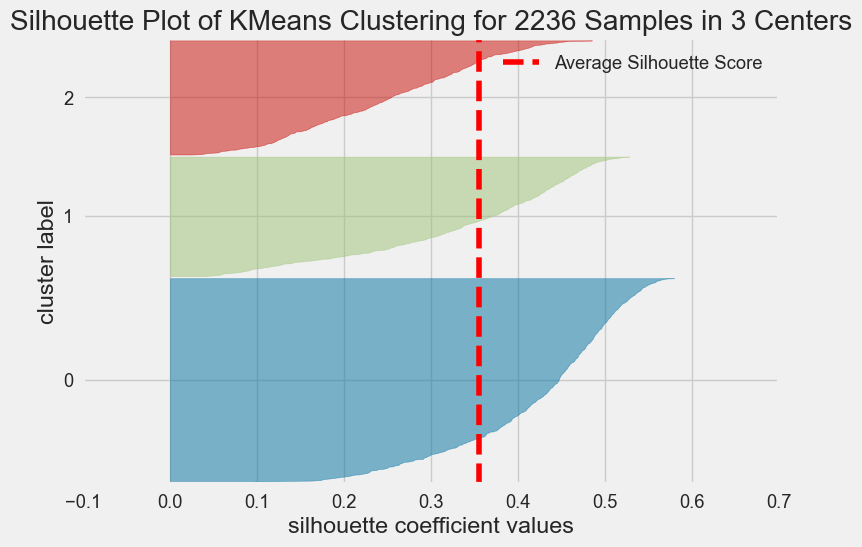

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2236 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [63]:
#Kmeans con k=3 (el que elegimos)
silhouette_visualizer(KMeans(3, n_init=10, random_state=42), df_pca, colors='yellowbrick')

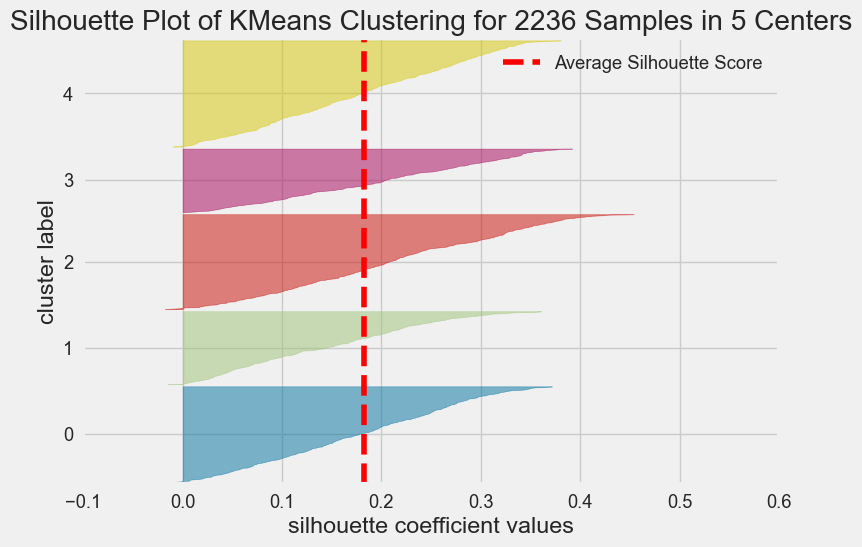

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2236 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, n_init=10, random_state=42))

In [64]:
#Kmeans con k=5
silhouette_visualizer(KMeans(5, n_init=10, random_state=42), df_pca, colors='yellowbrick')

Vamos a realizar la validacion externa con la variable Education.


In [65]:
#Validacion externa usando la variable Education


labels_true = df_cat['Education']
labels_pred = df_pca['kmeans']

adjusted_rand_score(labels_true, labels_pred)

-0.0035153613978854076

In [66]:
#Validacion externa usando la variable Marital_Status

labels_true = df_cat['Marital_Status']
labels_pred = df_pca['kmeans']

adjusted_rand_score(labels_true, labels_pred)

0.0038595438518118134

De acuerdo a los resultados obtenidos, concluimos que hay poca relacion entre los grupos establecidos y las variables Education y Marital_Status.

Implementar un segúndo método de clustering sobre los datos. El método dependerá del número de documento del/de la estudiante:

** DNI par (0, 2, ..., 8): realizar un clustering jerárquico.

** DNI impar (1, 3, ..., 9): realizar DBScan.

En cualquiera de los dos casos, deberá establecer los parámetros óptimos para realizar el clustering.

C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\3293261765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.drop('kmeans', axis=1, inplace=True)


Text(0, 0.5, 'Distancia')

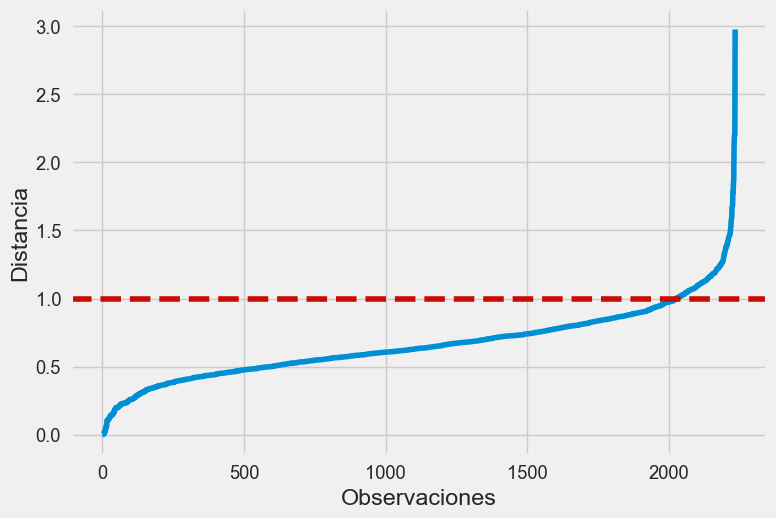

In [67]:
df_pca.drop('kmeans', axis=1, inplace=True)
k = 3
data_nn = df_pca.copy()

# Calculamos los vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Obtenemos las distancias
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.xlabel("Observaciones")
plt.ylabel("Distancia")

In [68]:
#Realizamos el clustering
dbscan_clusters = DBSCAN(eps = 1, min_samples = 5).fit(df_pca)
#Las observaciones que quedan con un valor de -1 son los puntos ruido (o outliers). Por lo que son las observaciones que no asigno a ningun cluster
dbscan_clusters.labels_


array([-1,  0,  0, ...,  6,  0,  0], dtype=int64)

In [69]:
df_pca['dbscan'] = pd.Series(dbscan_clusters.labels_)
df_pca.head()

C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\4177821246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca['dbscan'] = pd.Series(dbscan_clusters.labels_)


,PC1,PC2,PC3,PC4,PC5,dbscan
0,4.280897,1.186103,1.445661,-0.311535,-0.460245,-1
1,-2.549095,-0.706024,-1.885973,-0.478977,0.985721,0
2,1.938859,-0.285752,-0.179393,0.425684,1.035372,0
3,-2.543827,-1.161264,0.525144,0.650233,0.616803,0
4,-0.171148,0.184107,-0.041137,-1.145452,-0.654204,0


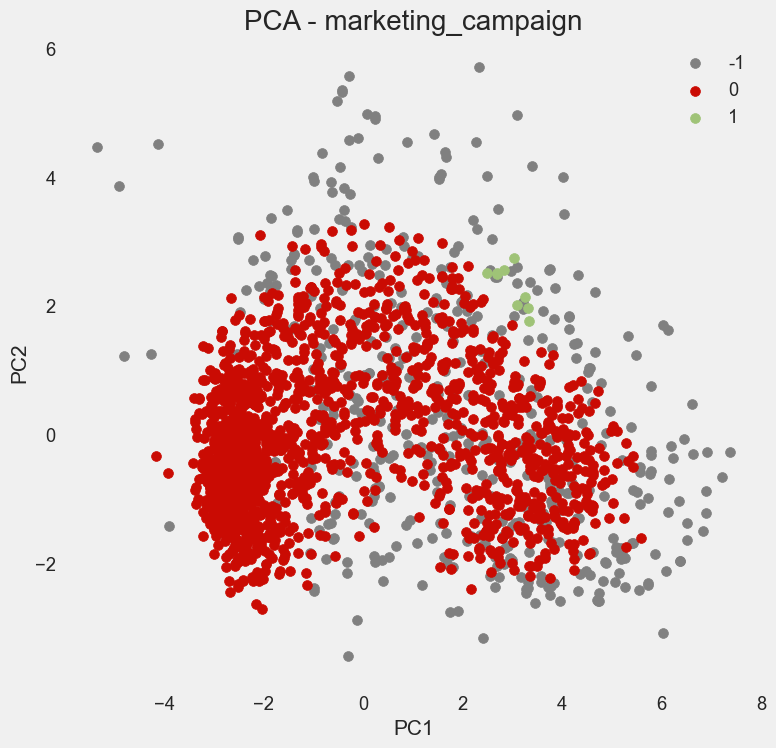

In [70]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA - marketing_campaign', fontsize = 20)
targets = [-1, 0, 1]
colors = ['gray', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['dbscan'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1']
               , df_pca.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Como podemos observar en la grafica, DBScan no es un metodo adecuado para este dataset, ya que no se pueden distinguir los clusters.

ÚLTIMO PUNTO: Interpretar los clusters que formó! ¿Qué caracteriza a los clientes que pertenecen a un determinado cluster? Tenga en cuenta que como el clustering lo está haciendo sobre el espacio de baja dimensionalidad (PCA) va a tener que pensar muy bien este punto...

In [71]:
#Nos ayudamos con la tabla de loadings para ver que caracteriza a los clientes de cada cluster elegido
loadings = pd.DataFrame(pca.components_.T,columns=component_names,index=df_num.columns,)
loadings.iloc[:, :3]


,PC1,PC2,PC3
ID,-0.004088,-0.043398,0.012147
Income,0.318475,-0.012815,-0.258338
Recency,0.006739,0.013088,-0.044709
MntWines,0.293162,0.196998,-0.115481
MntFruits,0.265073,-0.084520,0.182664
MntMeatProducts,0.309867,-0.087864,0.048386
MntFishProducts,0.274903,-0.089123,0.172023
MntSweetProducts,0.263896,-0.062891,0.166255
MntGoldProds,0.216083,0.164475,0.159682
NumDealsPurchases,-0.047694,0.562288,-0.060907


De esta tabla ya podemos obtener el perfil de cada cluster, pero vamos a graficarlos para verlos mejor.

In [72]:
AC = AgglomerativeClustering(n_clusters=3)
df_aux = AC.fit_predict(df_pca)
df_pca["Clusters"] = df_aux
df["Clusters"]= df_aux

C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\15778475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca["Clusters"] = df_aux


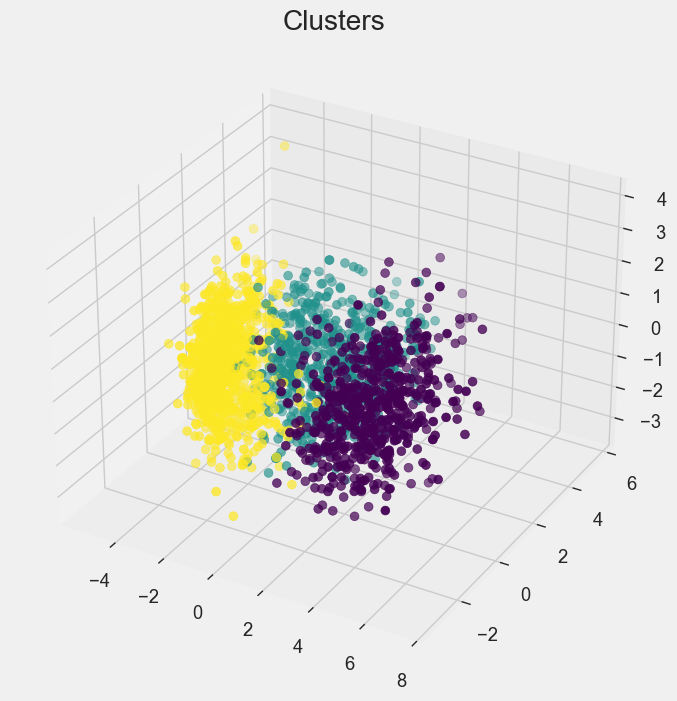

In [73]:
#Ploteo los clusters
x=df_pca['PC1']
y=df_pca['PC2'] 
z=df_pca['PC3'] 

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=df_pca["Clusters"], marker='o', cmap = 'viridis'  )
ax.set_title("Clusters")
plt.show()

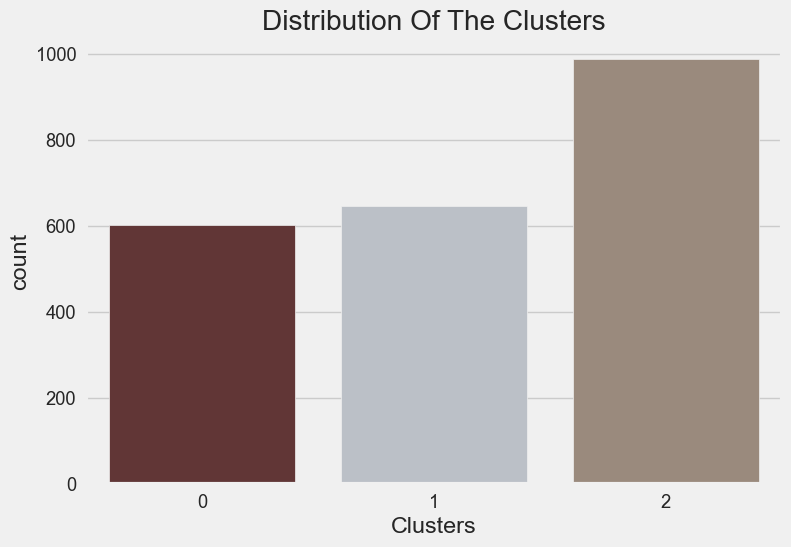

In [74]:
#Grafica de distribucion grupal de los clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df_pca["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()


C:\Users\sebag\AppData\Local\Temp\ipykernel_21800\2272066287.py:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  pl = sns.scatterplot(data = df_pca,x=df_num["Dinero_gastado"], y=df_num["Income"],hue=df_pca["Clusters"], palette= pal)


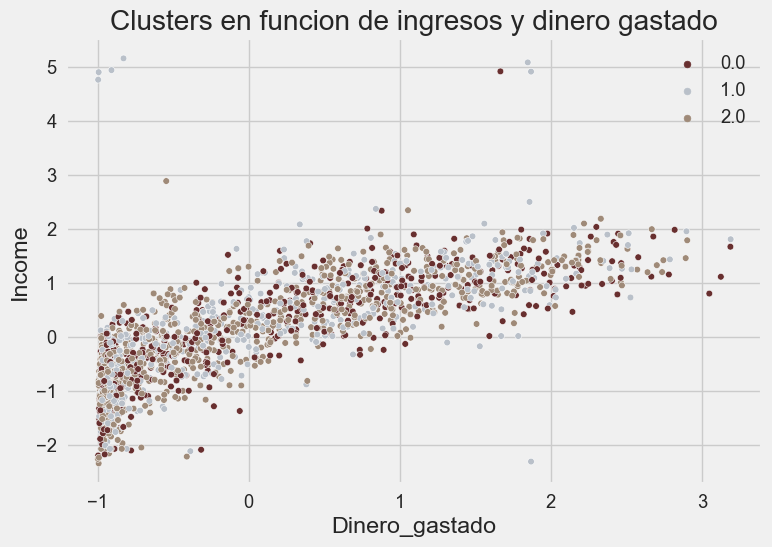

In [75]:
pl = sns.scatterplot(data = df_pca,x=df_num["Dinero_gastado"], y=df_num["Income"],hue=df_pca["Clusters"], palette= pal)
pl.set_title("Clusters en funcion de ingresos y dinero gastado")
plt.legend()
plt.show()

De la tabla y los graficos podemos concluir:
    *Cluster 1: 
            *Son los clientes con mayores ingresos y que mas dinero gastan en la empresa.
            *El producto que mas compran es carne
            *El segundo producto que mas compran es bebibas alcoholicas
            *Son en su mayoria Jovenes
            *No tienen hijos
            *La mayoria de sus compras son por catalogo
    *Cluster 2:
            *Realizan la mayoria de sus compras por internet
            *Compran la mayoria de sus productos en oferta
            *Poseen bajos ingresos
            *Tienen hijos
            *Sus principales compras son vino y pescado
    *Cluster 3:
            *Son los clientes de mayor edad
            *Son los que llevan mas tiempo siendo clientes
            *Tienen hijos
            *Poseen Ingresos medios
            *Son los que menos dinero gastan
            *El producto que mas compran es fruta


                